## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [6]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [7]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [8]:
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('The', 'DET'), ('loudest', 'ADJ'), ('of', 'ADP'), ('these', 'DET'), ('reformers', 'NOUN'), ('are', 'VERB'), ('money', 'NOUN'), ('managers', 'NOUN'), ('who', 'PRON'), ('*T*-77', 'X'), ('cater', 'VERB'), ('to', 'PRT'), ('smaller', 'ADJ'), ('investors', 'NOUN'), ('.', '.')], [('This', 'DET'), ('provision', 'NOUN'), ('amounts', 'VERB'), ('to', 'PRT'), ('a', 'DET'), ('legislative', 'ADJ'), ('veto', 'NOUN'), ('over', 'ADP'), ('the', 'DET'), ('president', 'NOUN'), ("'s", 'PRT'), ('execution', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('law', 'NOUN'), (',', '.'), ('since', 'ADP'), ('a', 'DET'), ('one-house', 'ADJ'), ('resolution', 'NOUN'), ('could', 'VERB'), ('be', 'VERB'), ('said', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('``', '.'), ('duly', 'ADV'), ('adopted', 'VERB'), ("''", '.'), ('even', 'ADV'), ('though', 'ADP'), ('it', 'PRON'), ('would', 'VERB'), ('require', 'VERB'), ('neither', 'DET'), ('bicameral', 'ADJ'), ('action', 'NOUN'), ('in', 'ADP'), ('Congress', 'NOUN'

In [9]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95835

In [10]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['The',
 'loudest',
 'of',
 'these',
 'reformers',
 'are',
 'money',
 'managers',
 'who',
 '*T*-77']

In [11]:
# vocabulary
V = set(tokens)
print(len(V))

12107


In [12]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'ADV', 'NUM', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'CONJ', 'PRT', 'VERB', 'X', 'PRON'}


### Build the vanilla Viterbi based POS tagger

In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[7.91318864e-02, 3.17195319e-02, 6.91151917e-02, 1.30217031e-01,
        3.07178628e-02, 1.37562603e-01, 1.19532555e-01, 7.01168599e-03,
        1.46911517e-02, 3.41569275e-01, 2.37061772e-02, 1.50250420e-02],
       [3.28849023e-03, 1.85052320e-01, 3.28849023e-03, 3.31838578e-02,
        3.52466375e-01, 1.14200301e-01, 3.52765322e-02, 1.43497754e-02,
        2.69058291e-02, 1.76382661e-02, 2.12855011e-01, 1.49476831e-03],
       [1.23857623e-02, 2.17652712e-02, 5.53150568e-03, 2.06108704e-01,
        6.35642111e-01, 1.79172680e-02, 9.62000992e-03, 4.81000490e-04,
        2.40500245e-04, 4.01635394e-02, 4.64165471e-02, 3.72775365e-03],
       [4.58490243e-03, 2.09595542e-02, 4.58490243e-03, 6.54986054e-02,
        7.00835109e-01, 6.41886368e-02, 7.74521008e-02, 1.71933845e-02,
        1.09710172e-02, 1.19534964e-02, 2.11233012e-02, 6.54986070e-04],
       [1.69077720e-02, 9.36486572e-03, 1.33002950e-02, 1.20249242e-02,
        2.64475465e-01, 2.40717128e-01, 1.76146924e-01, 4.21

In [17]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,ADV,NUM,DET,ADJ,NOUN,.,ADP,CONJ,PRT,VERB,X,PRON
ADV,0.079132,0.031720,0.069115,0.130217,0.030718,0.137563,0.119533,0.007012,0.014691,0.341569,0.023706,0.015025
NUM,0.003288,0.185052,0.003288,0.033184,0.352466,0.114200,0.035277,0.014350,0.026906,0.017638,0.212855,0.001495
DET,0.012386,0.021765,0.005532,0.206109,0.635642,0.017917,0.009620,0.000481,0.000241,0.040164,0.046417,0.003728
ADJ,0.004585,0.020960,0.004585,0.065499,0.700835,0.064189,0.077452,0.017193,0.010971,0.011953,0.021123,0.000655
NOUN,0.016908,0.009365,0.013300,0.012025,0.264475,0.240717,0.176147,0.042160,0.044019,0.146959,0.029151,0.004774
.,0.052646,0.080801,0.173936,0.044333,0.221040,0.094029,0.091527,0.058455,0.002503,0.087862,0.026904,0.065874
ADP,0.013342,0.061373,0.323620,0.107802,0.321806,0.040559,0.016651,0.000854,0.001494,0.008112,0.035329,0.069058
CONJ,0.054807,0.042731,0.120297,0.117975,0.347887,0.036229,0.051091,0.000464,0.004645,0.155132,0.008825,0.059916
PRT,0.009769,0.056985,0.102572,0.085314,0.246825,0.042006,0.020514,0.001954,0.001954,0.399870,0.013676,0.018561
VERB,0.080842,0.021837,0.134660,0.065665,0.109416,0.035233,0.092071,0.005420,0.031594,0.169738,0.218213,0.035311


In [18]:
tags_df.loc['.', :]

ADV     0.052646
NUM     0.080801
DET     0.173936
ADJ     0.044333
NOUN    0.221040
.       0.094029
ADP     0.091527
CONJ    0.058455
PRT     0.002503
VERB    0.087862
X       0.026904
PRON    0.065874
Name: ., dtype: float32

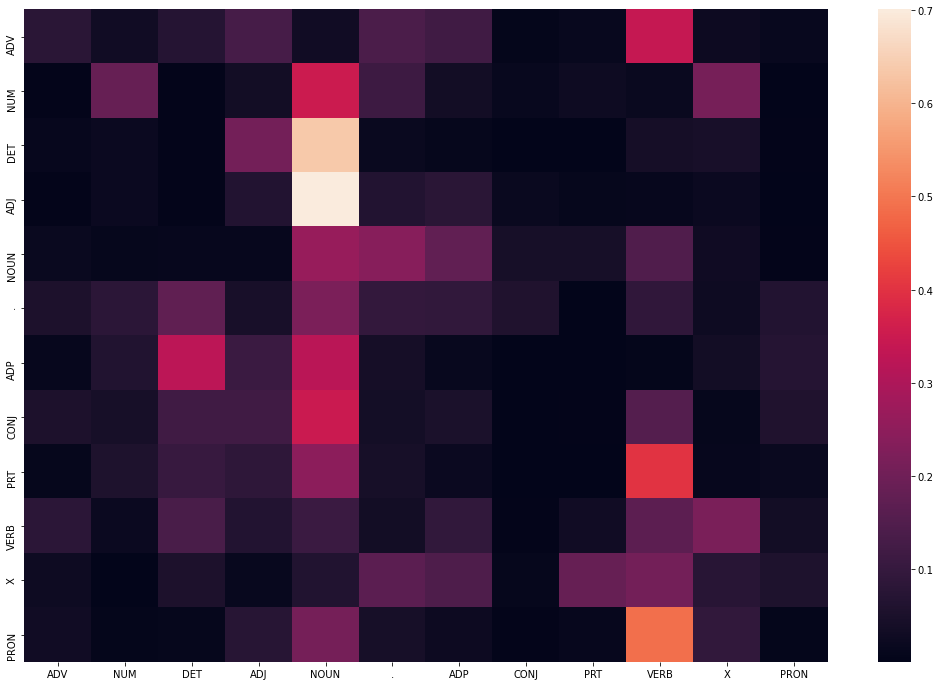

In [19]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

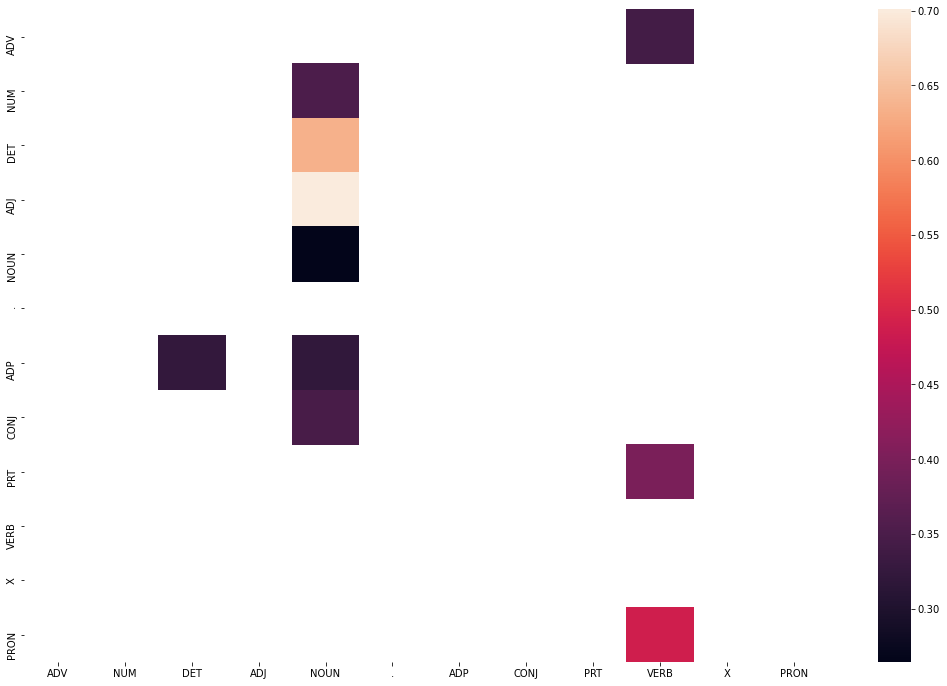

In [20]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [21]:
len(train_tagged_words)

95835

In [22]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('In', 'ADP'),
  ('addition', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('big', 'ADJ'),
  ('loan', 'NOUN'),
  ('that', 'ADP'),
  ('First', 'NOUN'),
  ('Boston', 'NOUN'),
  ('made', 'VERB'),
  ('*T*-2', 'X'),
  ('to', 'PRT'),
  ('Ohio', 'NOUN'),
  ('Mattress', 'NOUN'),
  ('Co', 'NOUN'),
  ('.', '.'),
  ('was', 'VERB'),
  ("n't", 'ADV'),
  ('repaid', 'VERB'),
  ('on', 'ADP'),
  ('time', 'NOUN'),
  ('when', 'ADV'),
  ('its', 'PRON'),
  ('$', '.'),
  ('450', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('junk', 'NOUN'),
  ('financing', 'NOUN'),
  ('for', 'ADP'),
  ('a', 'DET'),
  ('buy-out', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('bedding', 'NOUN'),
  ('company', 'NOUN'),
  ('was', 'VERB'),
  ('withdrawn', 'VERB'),
  ('*-1', 'X'),
  ('*T*-3', 'X'),
  ('.', '.')],
 [('Douglas', 'NOUN'),
  ('Madison', 'NOUN'),
  (',', '.'),
  ('a', 'DET'),
  ('corporate', 'ADJ'),
  ('trader', 'NOUN'),
  ('with', 'ADP'),
  ('Bank', 'NOUN'),
  ('of', 'ADP'),
  ('America', 'NOUN'),
  ('in', 'ADP'),


In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  72.32069134712219
[('In', 'ADP'), ('addition', 'NOUN'), (',', '.'), ('a', 'DET'), ('big', 'ADJ'), ('loan', 'NOUN'), ('that', 'ADP'), ('First', 'NOUN'), ('Boston', 'NOUN'), ('made', 'VERB'), ('*T*-2', 'X'), ('to', 'PRT'), ('Ohio', 'NOUN'), ('Mattress', 'ADV'), ('Co', 'NOUN'), ('.', '.'), ('was', 'VERB'), ("n't", 'ADV'), ('repaid', 'VERB'), ('on', 'ADP'), ('time', 'NOUN'), ('when', 'ADV'), ('its', 'PRON'), ('$', '.'), ('450', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('junk', 'NOUN'), ('financing', 'NOUN'), ('for', 'ADP'), ('a', 'DET'), ('buy-out', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('bedding', 'ADV'), ('company', 'NOUN'), ('was', 'VERB'), ('withdrawn', 'VERB'), ('*-1', 'X'), ('*T*-3', 'X'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('in', 'ADP'), ('Los', 'NOUN'), ('Angeles', 'NOUN'), (',', '.'), ('traced', 'AD

In [25]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

0.9526627218934911

In [26]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('Ohio', 'NOUN'), (('Mattress', 'ADV'), ('Mattress', 'NOUN'))],
 [('the', 'DET'), (('bedding', 'ADV'), ('bedding', 'NOUN'))],
 [(',', '.'), (('traced', 'ADV'), ('traced', 'VERB'))],
 [('another', 'DET'), (('wave', 'ADV'), ('wave', 'NOUN'))],
 [('.', '.'), (('Second', 'NOUN'), ('Second', 'ADJ'))],
 [('they', 'PRON'), (('channel', 'ADV'), ('channel', 'VERB'))],
 [('administrative', 'ADJ'), (('burden', 'ADV'), ('burden', 'NOUN'))],
 [('the', 'DET'), (('dilemma', 'ADV'), ('dilemma', 'NOUN'))]]

In [27]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'ADV'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADV'), ('.', '.'), ('Android', 'ADV'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADV'), ('worldwide', 'ADV'), ('on', 'ADP'), ('smartphones', 'ADV'), ('since', 'ADP'), ('2011', 'ADV'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADV'), ('.', '.'), ('Google', 'ADV'), ('and', 'CONJ'), ('Twitter', 'ADV'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADV'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADV'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADV'), ("'s", 'PRT'), ('firehose', 'ADV'), ('.', '.'), ('Twitter', 'ADV'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADV'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### Solve the problem of unknown words

In [28]:
###Version 1 : Rule Based Tagging with Viterbi

In [29]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [30]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Mattress
NOUN
bedding
VERB
traced
VERB
wave
NOUN
channel
NOUN
burden
NOUN
dilemma
NOUN
Time taken in seconds:  73.55143523216248
[('In', 'ADP'), ('addition', 'NOUN'), (',', '.'), ('a', 'DET'), ('big', 'ADJ'), ('loan', 'NOUN'), ('that', 'ADP'), ('First', 'NOUN'), ('Boston', 'NOUN'), ('made', 'VERB'), ('*T*-2', 'X'), ('to', 'PRT'), ('Ohio', 'NOUN'), ('Mattress', 'NOUN'), ('Co', 'NOUN'), ('.', '.'), ('was', 'VERB'), ("n't", 'ADV'), ('repaid', 'VERB'), ('on', 'ADP'), ('time', 'NOUN'), ('when', 'ADV'), ('its', 'PRON'), ('$', '.'), ('450', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('junk', 'NOUN'), ('financing', 'NOUN'), ('for', 'ADP'), ('a', 'DET'), ('buy-out', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('bedding', 'VERB'), ('company', 'NOUN'), ('was', 'VERB'), ('withdrawn', 'VERB'), ('*-1', 'X'), ('*T*-3', 'X'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America',

In [31]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9822485207100592


In [32]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('the', 'DET'), (('bedding', 'VERB'), ('bedding', 'NOUN'))],
 [('.', '.'), (('Second', 'NOUN'), ('Second', 'ADJ'))],
 [('they', 'PRON'), (('channel', 'NOUN'), ('channel', 'VERB'))]]

In [33]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

In [34]:
###Version 2 : Rule Based Tagging with Viterbi

def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [35]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

Mattress
NOUN
bedding
VERB
traced
VERB
wave
NOUN
channel
NOUN
burden
NOUN
dilemma
NOUN
Time taken in seconds:  76.60044932365417
[('In', 'ADP'), ('addition', 'NOUN'), (',', '.'), ('a', 'DET'), ('big', 'ADJ'), ('loan', 'NOUN'), ('that', 'ADP'), ('First', 'NOUN'), ('Boston', 'NOUN'), ('made', 'VERB'), ('*T*-2', 'X'), ('to', 'PRT'), ('Ohio', 'NOUN'), ('Mattress', 'NOUN'), ('Co', 'NOUN'), ('.', '.'), ('was', 'VERB'), ("n't", 'ADV'), ('repaid', 'VERB'), ('on', 'ADP'), ('time', 'NOUN'), ('when', 'ADV'), ('its', 'PRON'), ('$', '.'), ('450', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('junk', 'NOUN'), ('financing', 'NOUN'), ('for', 'ADP'), ('a', 'DET'), ('buy-out', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('bedding', 'VERB'), ('company', 'NOUN'), ('was', 'VERB'), ('withdrawn', 'VERB'), ('*-1', 'X'), ('*T*-3', 'X'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America',

In [36]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9822485207100592


[[('the', 'DET'), (('bedding', 'VERB'), ('bedding', 'NOUN'))],
 [('.', '.'), (('Second', 'NOUN'), ('Second', 'ADJ'))],
 [('they', 'PRON'), (('channel', 'NOUN'), ('channel', 'VERB'))]]

In [37]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [38]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9526627218934911
Lexicon Based Viterbi Accuracy: 0.9822485207100592
Rule Based Viterbi Accuracy: 0.9822485207100592


##### Lexicon Based Viterbi & Rule Based Viterbi 's accuracy are greater than Plain Vannila Viterbi's accuracy

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

* Words like 'Twitter', 'Android', 'Google' are properly tagged with 'NOUN' in modified Viterbi Algorithm
* Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (All Caps of a word generally will be an abbrevation and it is a noun)
* Words ending with '-ing' like 'arriving' and words ending with '-ed' like 'invited' are properly tagged as 'VERB' in Rule Based Tagging
* Words with integers or float are properly tagged as 'NUM' are properly tagged as NUM in rule based tagger
* In Lexicon tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers cannot able to tag them. And it corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc.